In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Data Loading
# Loading the cleaned data from the previous step
try:
    df = pd.read_csv('../data/cleaned_data.csv')
    print("✅ Dataset loaded successfully.")

    # Convert Date to datetime object for Recency calculation
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        print("❌ Error: Date column is missing!")
except FileNotFoundError:
    print("❌ Error: File not found. Please check the path.")

✅ Dataset loaded successfully.


In [3]:
# 3. Feature Engineering: RFM Analysis
# We need to group transaction data by Customer to create a profile.
# Recency: Days since last purchase
# Frequency: Total number of purchases
# Monetary: Total money spent

# Assume the analysis date is 1 day after the max date in the dataset
snapshot_date = df['Date'].max() + pd.to_timedelta(1, unit='D')

rfm = df.groupby('Customer ID').agg({
    'Date': lambda x: (snapshot_date - x.max()).days, # Recency
    'Transaction ID': 'count',                        # Frequency
    'Total Amount': 'sum'                             # Monetary
})

# Rename columns for clarity
rfm.rename(columns={
    'Date': 'Recency',
    'Transaction ID': 'Frequency',
    'Total Amount': 'Monetary'
}, inplace=True)

print("\nRFM Data Sample (First 5 Customers):")
print(rfm.head())


RFM Data Sample (First 5 Customers):
             Recency  Frequency  Monetary
Customer ID                              
CUST001           39          1        60
CUST002          309          1       224
CUST003          354          1       929
CUST004          226          1       293
CUST005          241          1        80


In [4]:
# 4. Data Preprocessing (Scaling)
# K-Means is sensitive to scale. We must normalize the data.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_normalized = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)

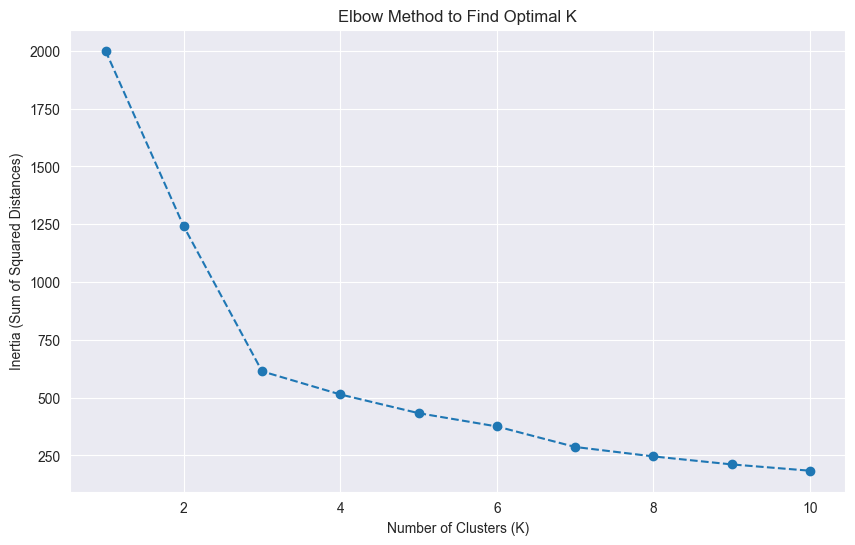

In [5]:
# 5. Finding Optimal K (The Elbow Method)
# We test cluster counts from 1 to 10 to find the "elbow" point.
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)

# Visualization 1: The Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method to Find Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()

In [6]:
# 6. Model Training (K-Means)
# Based on retail logic, we usually aim for 3 or 4 segments (e.g., Low, Mid, High Value)
# Let's choose K=4 for granular segmentation
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

In [7]:
# 7. Evaluation
score = silhouette_score(rfm_normalized, rfm['Cluster'])
print(f"\n🎯 Silhouette Score: {score:.2f} (Closer to 1 is better)")

# Analyze the Cluster Centers (Who are these people?)
cluster_summary = rfm.groupby('Cluster').mean()
print("\n📊 Cluster Profiles (Average Values):")
print(cluster_summary)


🎯 Silhouette Score: 0.45 (Closer to 1 is better)

📊 Cluster Profiles (Average Values):
            Recency  Frequency     Monetary
Cluster                                    
0        270.319892        1.0   275.551075
1         87.201005        1.0   417.668342
2        136.141593        1.0  2425.477876
3        276.350427        1.0  1268.726496


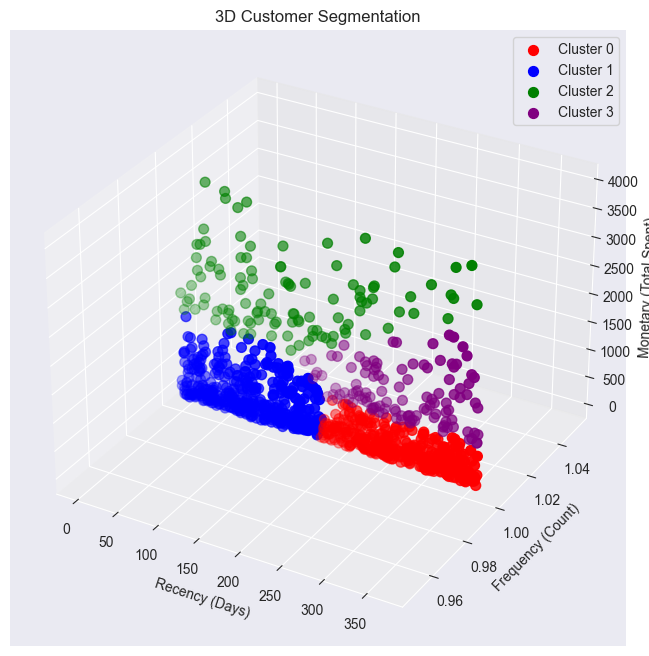

In [8]:
# 8. Visualizations

# Visualization 2: 3D Scatter Plot (The "Cool" Graph)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'green', 'purple']

for i in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == i]
    ax.scatter(cluster_data['Recency'],
               cluster_data['Frequency'],
               cluster_data['Monetary'],
               c=colors[i], label=f'Cluster {i}', s=50)

ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Count)')
ax.set_zlabel('Monetary (Total Spent)')
ax.set_title('3D Customer Segmentation')
plt.legend()
plt.show()

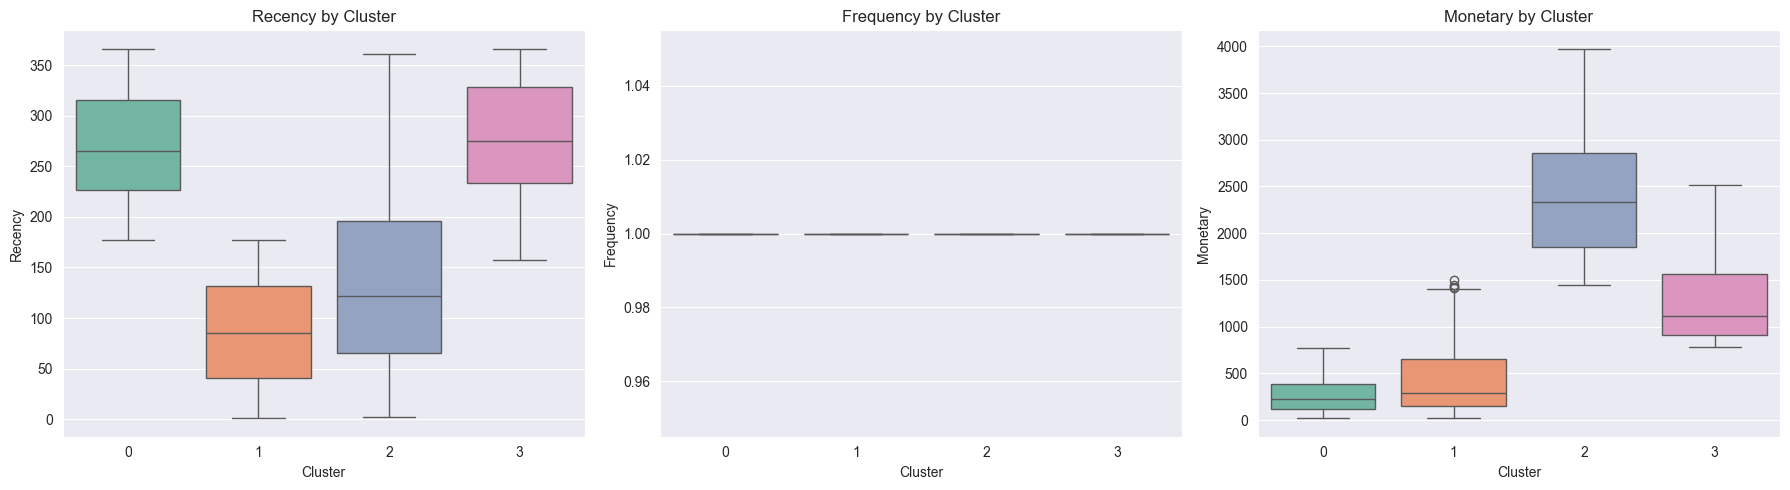

In [9]:
# Visualization 3: Box Plots for Cluster Profiling
# Shows the distribution of each feature per cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0], palette="Set2")
axes[0].set_title('Recency by Cluster')

sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1], palette="Set2")
axes[1].set_title('Frequency by Cluster')

sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2], palette="Set2")
axes[2].set_title('Monetary by Cluster')

plt.tight_layout()
plt.show()

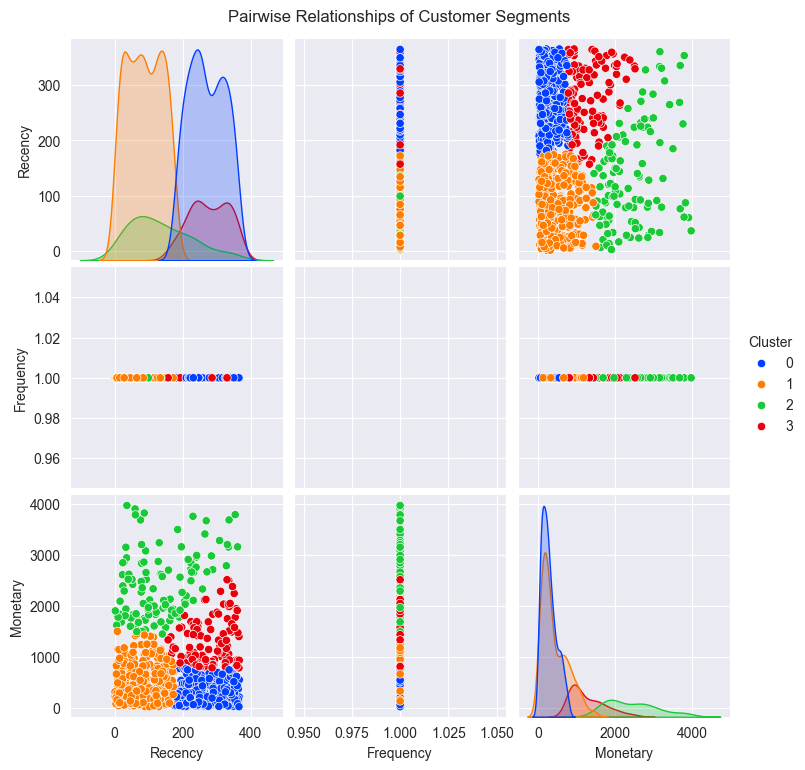

In [10]:
# Visualization 4: Pairplot to see 2D relationships
sns.pairplot(rfm, hue='Cluster', palette="bright")
plt.suptitle("Pairwise Relationships of Customer Segments", y=1.02)
plt.show()

In [11]:
# 9. Saving the Model
# Important for the UI/Web Interface part
model_path = '../models/kmeans_model.pkl'
scaler_path = '../models/scaler_rfm.pkl'

# Ensure directory exists
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

joblib.dump(kmeans, model_path)
joblib.dump(scaler, scaler_path)

# Save the segmented data for analysis
rfm.to_csv('../data/customer_segments.csv')

print(f"\n💾 Model saved to: {model_path}")
print(f"💾 Scaler saved to: {scaler_path}")
print("💾 Segmented customer data saved to: ../data/customer_segments.csv")


💾 Model saved to: ../models/kmeans_model.pkl
💾 Scaler saved to: ../models/scaler_rfm.pkl
💾 Segmented customer data saved to: ../data/customer_segments.csv
